In [1]:
##Import Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [2]:
image_size=300
batch_size=32

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "lemon_dataset",
    seed=123,
    shuffle=True,
    batch_size=batch_size,
    image_size=(image_size,image_size)
)

Found 2528 files belonging to 3 classes.


In [4]:
dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [5]:
class_names=dataset.class_names

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())


(32, 300, 300, 3)
[0 0 2 2 2 1 0 2 1 0 2 2 2 0 2 2 2 2 0 2 0 1 2 2 2 1 2 2 2 2 0 2]


In [7]:
len(dataset)*batch_size #In this dataset there are 79 batches and each batch have 32 images so 79*32 is total files


2528

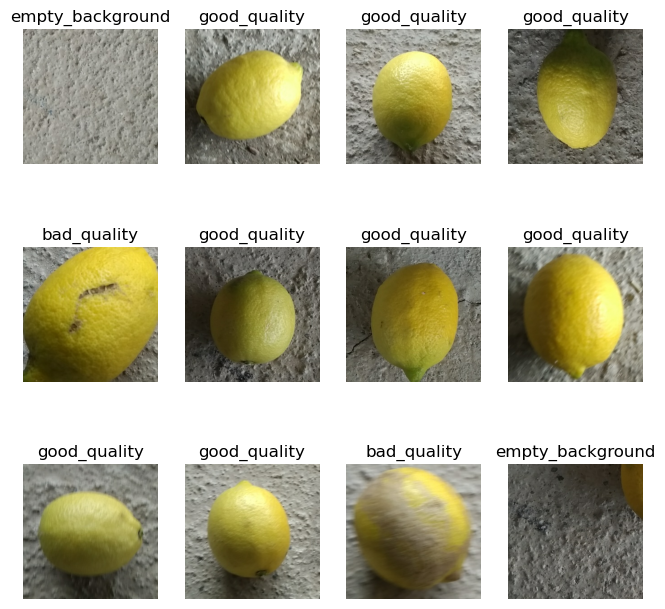

In [8]:
plt.figure(figsize=(8,8))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")


In [9]:
def split_dataset(dataset , train_split=0.8, test_split=0.1, val_split=0.1 , shuffle=True , shuffle_size= 10000 ):
    assert(train_split+test_split+val_split) == 1
    
    ds_size=len(dataset)
    
    if shuffle:
        dataset=dataset.shuffle(shuffle_size , seed=12)
        
    train_size=int(ds_size*train_split)
    val_size=int(ds_size*val_split)
    
    train_ds=dataset.take(train_size)
    val_ds=dataset.skip(train_size).take(val_size)
    test_ds=dataset.skip(train_size).skip(val_size)
    
    return train_ds, test_ds, val_ds

In [10]:
train_ds, test_ds, val_ds=split_dataset(dataset)

In [11]:
print("train_ds:",len(train_ds))
print("test_ds:",len(test_ds))
print("val_ds:",len(val_ds))

train_ds: 63
test_ds: 9
val_ds: 7


In [12]:
# cache, shuffle,prefetch the dataset
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [13]:
resize_and_rescale= tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(image_size,image_size),
    layers.experimental.preprocessing.Rescaling(1./299),
])

In [14]:
Data_augmentation= tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [15]:
# applying data augmentation in train_ds

In [16]:
train_ds=train_ds.map(lambda x, y:(Data_augmentation(x,training=True),y)).prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
channel=3
n_classes=3

In [18]:
input_shape=(batch_size , image_size , image_size,channel)

model=models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32 , kernel_size=(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64 , kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64 , kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64 , kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64 , kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64 , kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
    
    
])

In [19]:
model.build(input_shape=input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 300, 300, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 298, 298, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 149, 149, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 147, 147, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 73, 73, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 71, 71, 64)         

In [20]:
## Early stopping
early_stopping=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.0001,
    patience=20,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

In [21]:
# compile model

model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
    
    

)

In [22]:
history=model.fit(
    train_ds,  
    batch_size=batch_size,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
    callbacks=early_stopping

)

Epoch 1/10
63/63 [==============================] - 315s 4s/step - loss: 0.6350 - accuracy: 0.6612 - val_loss: 0.4936 - val_accuracy: 0.8036
Epoch 2/10
63/63 [==============================] - 258s 4s/step - loss: 0.4029 - accuracy: 0.8194 - val_loss: 0.3881 - val_accuracy: 0.8214
Epoch 3/10
63/63 [==============================] - 245s 4s/step - loss: 0.3085 - accuracy: 0.8656 - val_loss: 0.3052 - val_accuracy: 0.9107
Epoch 4/10
63/63 [==============================] - 237s 4s/step - loss: 0.2078 - accuracy: 0.9157 - val_loss: 0.1381 - val_accuracy: 0.9375
Epoch 5/10
63/63 [==============================] - 242s 4s/step - loss: 0.1736 - accuracy: 0.9296 - val_loss: 0.1646 - val_accuracy: 0.9464
Epoch 6/10
63/63 [==============================] - 246s 4s/step - loss: 0.1506 - accuracy: 0.9420 - val_loss: 0.0860 - val_accuracy: 0.9554
Epoch 7/10
63/63 [==============================] - 212s 3s/step - loss: 0.1438 - accuracy: 0.9375 - val_loss: 0.0997 - val_accuracy: 0.9598
Epoch 8/10
63

In [23]:
scores=model.evaluate(test_ds)
scores

9/9 [==============================] - 18s 806ms/step - loss: 0.0385 - accuracy: 0.9826


[0.038539305329322815, 0.9826388955116272]

In [24]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 63}

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [32]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

In [33]:
epochs=10

Text(0.5, 1.0, 'Training and Validation Loss')

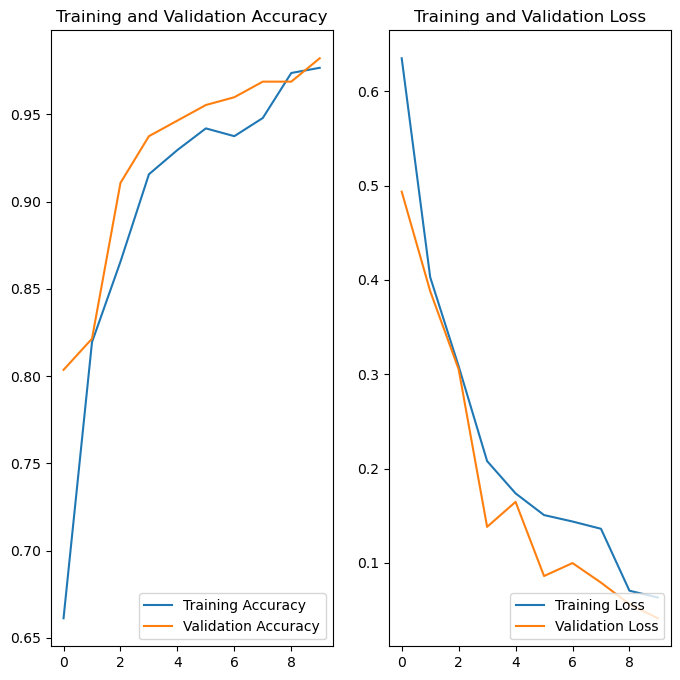

In [34]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(epochs),acc,label="Training Accuracy")
plt.plot(range(epochs),val_acc,label="Validation Accuracy")
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(epochs),loss,label="Training Loss")
plt.plot(range(epochs),val_loss,label="Validation Loss")
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')

## Prediction

first image to predict
actual label bad_quality
1/1 [==============================] - 1s 574ms/step
predicted label bad_quality


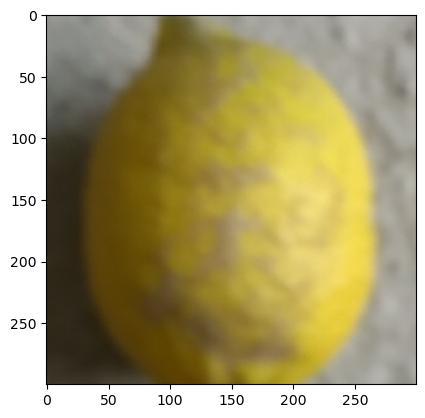

In [40]:
for image_batch, labels_batch in test_ds.take(1):
    first_image= image_batch[0].numpy().astype('uint8')
    first_label= labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label", class_names[first_label])
    
    batch_prediction= model.predict(image_batch)
    print("predicted label",class_names[np.argmax(batch_prediction[0])])

In [38]:
# Save model

In [39]:
model.save("lemon.h5")